In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

In [3]:
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

pd.set_option('display.max_columns', 500)

In [4]:
# Import and store dataset
fraud_data = pd.read_csv('imbalancedFraudDF.csv')
ipToCountry = pd.read_csv('IpAddress_to_Country.csv')

In [5]:
import sklearn
print(sklearn.__version__)

0.21.3


In [8]:
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import seaborn as sns
%matplotlib inline

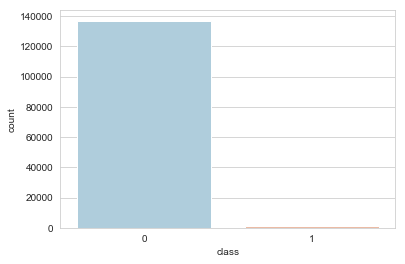

In [24]:
sns.set_style('whitegrid')
sns.countplot(x='class',data=fraud_data,palette='RdBu_r')

In [6]:
#Distribution of the label column
fraud_data['class'].value_counts()

0    136961
1      1415
Name: class, dtype: int64

In [9]:
fraud_data.head(3)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0


In [10]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138376 entries, 0 to 138375
Data columns (total 11 columns):
user_id           138376 non-null int64
signup_time       138376 non-null object
purchase_time     138376 non-null object
purchase_value    138376 non-null int64
device_id         138376 non-null object
source            138376 non-null object
browser           138376 non-null object
sex               138376 non-null object
age               138376 non-null int64
ip_address        138376 non-null float64
class             138376 non-null int64
dtypes: float64(1), int64(4), object(6)
memory usage: 11.6+ MB


In [11]:
ipToCountry.head(2)

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China


In [12]:
#Task 1: Identify country info based on ip_address
start = time.time()

countries = []
for i in range(len(fraud_data)):
    ip_address = fraud_data.loc[i, 'ip_address']
    tmp = ipToCountry[(ipToCountry['lower_bound_ip_address'] <= ip_address) &
                    (ipToCountry['upper_bound_ip_address'] >= ip_address)]
    if len(tmp) == 1:#found match
        countries.append(tmp['country'].values[0])
    else:#no match
        countries.append('NA')
        
fraud_data['country'] = countries
print("Lookup took", time.time() - start, "seconds.")

Lookup took 147.58873391151428 seconds.


In [13]:
print(fraud_data.user_id.nunique())#138289
print (len(fraud_data.index))#138376

138376
138376


In [15]:
print(fraud_data['user_id'].nunique())

138376


In [17]:
#time related features: can be done before split, as they has no interaction between other rows, solely based on other columns of the same row
fraud_data['interval_after_signup'] = (pd.to_datetime(fraud_data['purchase_time']) - pd.to_datetime(
        fraud_data['signup_time'])).dt.total_seconds()

fraud_data['signup_days_of_year'] = pd.DatetimeIndex(fraud_data['signup_time']).dayofyear

fraud_data['signup_seconds_of_day'] = pd.DatetimeIndex(fraud_data['signup_time']).second + 60 * pd.DatetimeIndex(
    fraud_data['signup_time']).minute + 3600 * pd.DatetimeIndex(fraud_data['signup_time']).hour

fraud_data['purchase_days_of_year'] = pd.DatetimeIndex(fraud_data['purchase_time']).dayofyear
fraud_data['purchase_seconds_of_day'] = pd.DatetimeIndex(fraud_data['purchase_time']).second + 60 * pd.DatetimeIndex(
    fraud_data['purchase_time']).minute + 3600 * pd.DatetimeIndex(fraud_data['purchase_time']).hour

fraud_data = fraud_data.drop(['user_id','signup_time','purchase_time'], axis=1)


In [18]:
print(fraud_data.source.value_counts())

SEO       55766
Ads       54913
Direct    27697
Name: source, dtype: int64


In [19]:
print(fraud_data['source'].value_counts())

SEO       55766
Ads       54913
Direct    27697
Name: source, dtype: int64


In [20]:
fraud_data.head(2)

,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day
0,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,55,82549,108,10031
1,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,158,74390,159,5934


In [21]:
fraud_data.describe()

,purchase_value,age,ip_address,class,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day
count,138376.000000,138376.000000,1.383760e+05,138376.000000,1.383760e+05,138376.000000,138376.000000,138376.000000,138376.000000
mean,36.938985,33.125867,2.154381e+09,0.010226,5.164377e+06,114.412449,43131.536733,174.183991,43247.600191
std,18.321091,8.623645,1.250563e+09,0.100605,3.004642e+06,66.389783,24949.850767,75.410596,24935.829856
min,9.000000,18.000000,5.209350e+04,0.000000,1.000000e+00,1.000000,0.000000,1.000000,0.000000
25%,22.000000,27.000000,1.085079e+09,0.000000,2.549188e+06,57.000000,21452.750000,117.000000,21698.750000
50%,35.000000,33.000000,2.156471e+09,0.000000,5.165848e+06,114.000000,43216.000000,174.000000,43335.500000
75%,49.000000,39.000000,3.249150e+09,0.000000,7.768159e+06,172.000000,64676.000000,232.000000,64776.750000
max,154.000000,76.000000,4.294850e+09,1.000000,1.036797e+07,230.000000,86398.000000,350.000000,86399.000000


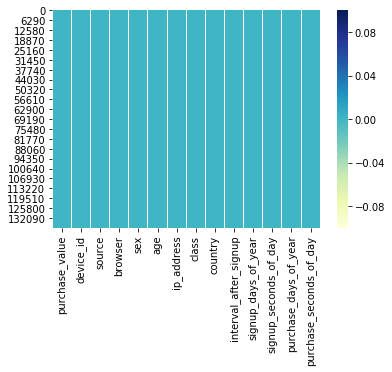

In [22]:
sns.heatmap(fraud_data.isnull(),cmap = 'YlGnBu')

In [23]:
fraud_data.shape

(138376, 14)

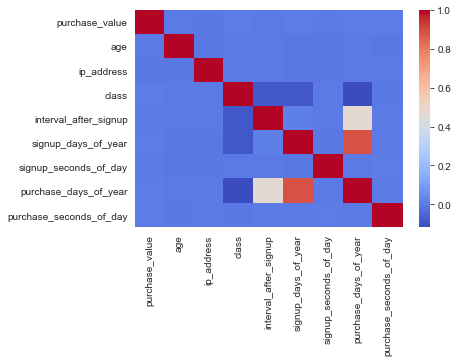

In [25]:
sns.heatmap(fraud_data.corr(),cmap = 'coolwarm')

In [26]:
fraud_data.corr()

,purchase_value,age,ip_address,class,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day
purchase_value,1.000000,0.001804,-0.000755,0.005138,0.003421,0.004596,0.004000,0.005619,0.005154
age,0.001804,1.000000,-0.000980,0.004006,0.004022,-0.000366,-0.000472,0.001533,-0.000309
ip_address,-0.000755,-0.000980,1.000000,0.001150,0.001669,-0.000535,-0.002602,0.000289,-0.000047
class,0.005138,0.004006,0.001150,1.000000,-0.087757,-0.088310,0.000697,-0.118196,-0.004403
interval_after_signup,0.003421,0.004022,0.001669,-0.087757,1.000000,0.015123,0.000386,0.474458,0.003276
signup_days_of_year,0.004596,-0.000366,-0.000535,-0.088310,0.015123,1.000000,-0.001340,0.887336,0.002630
signup_seconds_of_day,0.004000,-0.000472,-0.002602,0.000697,0.000386,-0.001340,1.000000,0.002806,0.005607
purchase_days_of_year,0.005619,0.001533,0.000289,-0.118196,0.474458,0.887336,0.002806,1.000000,0.000021
purchase_seconds_of_day,0.005154,-0.000309,-0.000047,-0.004403,0.003276,0.002630,0.005607,0.000021,1.000000


In [27]:
y = fraud_data['class']
X = fraud_data.drop(['class'], axis=1)

#split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)

X_train.shape: (110700, 13)
y_train.shape: (110700,)


In [28]:
X_train.head()

,purchase_value,device_id,source,browser,sex,age,ip_address,country,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day
29343,12,OULPAZAFRFPXP,Ads,Chrome,M,42,3.690922e+09,Korea Republic of,3499664.0,183,67384,224,24648
12190,10,AIIWMFEYQQIEB,Ads,Opera,M,29,1.686759e+09,United States,6766039.0,5,78146,84,18585
19388,34,VUVETBUPCIWJE,Direct,Chrome,M,53,4.138429e+09,NA,5870515.0,197,81354,265,76669
89104,48,QCFULAJOYKFUU,Ads,Chrome,M,29,9.617337e+07,France,2145618.0,160,30920,185,16538
82082,44,IHRWLMIJMEEEU,Ads,FireFox,M,24,1.936025e+09,China,7079059.0,111,71897,193,66156


In [29]:
#converting needs to be done after split
X_train = pd.get_dummies(X_train, columns=['source', 'browser'])#need to drop ['source', 'browser']? no, auto dropped by get_dummies 
X_train['sex'] = (X_train.sex == 'M').astype(int)

# the more a device is shared, the more suspicious
X_train['n_dev_shared'] = X_train.device_id.map(X_train.device_id.value_counts(dropna=False))

# the more a ip is shared, the more suspicious
X_train['n_ip_shared'] = X_train.ip_address.map(X_train.ip_address.value_counts(dropna=False))

# the less visit from a country, the more suspicious
X_train['n_country_shared'] = X_train.country.map(X_train.country.value_counts(dropna=False))#lots of NAs in country column, #without dropna=False will produce nan in this col

X_train = X_train.drop(['device_id','ip_address','country'], axis=1)


In [30]:
X_train.head(2)

,purchase_value,sex,age,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,n_dev_shared,n_ip_shared,n_country_shared
29343,12,1,42,3499664.0,183,67384,224,24648,1,0,0,1,0,0,0,0,1,1,3075
12190,10,1,29,6766039.0,5,78146,84,18585,1,0,0,0,0,0,1,0,1,1,42348


In [31]:
X_test = pd.get_dummies(X_test, columns=['source', 'browser'])
X_test['sex'] = (X_test.sex == 'M').astype(int)

# the more a device is shared, the more suspicious
X_test['n_dev_shared'] = X_test.device_id.map(X_test.device_id.value_counts(dropna=False))

# the more a ip is shared, the more suspicious
X_test['n_ip_shared'] = X_test.ip_address.map(X_test.ip_address.value_counts(dropna=False))

# the less visit from a country, the more suspicious
X_test['n_country_shared'] = X_test.country.map(X_test.country.value_counts(dropna=False))

X_test = X_test.drop(['device_id','ip_address','country'], axis=1)

In [32]:
# # normalize to [0,1], standardize(StandardScaler) to normal, mu=0,var = 1 can < 0, so we do normalize here

# needs to be brought to the same scale for models like LR with regularization(that are not tree based)

#Compute the train minimum and maximum to be used for later scaling:
scaler = preprocessing.MinMaxScaler().fit(X_train[['n_dev_shared', 'n_ip_shared', 'n_country_shared']]) 
#print(scaler.data_max_)

#transform the training data and use them for the model training
X_train[['n_dev_shared', 'n_ip_shared', 'n_country_shared']] = scaler.transform(X_train[['n_dev_shared', 'n_ip_shared', 'n_country_shared']])

#before the prediction of the test data, apply the same scaler obtained from above on X_test, not fitting a brandnew scaler on test
X_test[['n_dev_shared', 'n_ip_shared', 'n_country_shared']] = scaler.transform(X_test[['n_dev_shared', 'n_ip_shared', 'n_country_shared']])

In [ ]:
####shouldn't we scale all features????

In [33]:
X_train.n_dev_shared.value_counts(dropna=False)

0.0    105427
0.2      4774
0.4       324
0.6       124
0.8        45
1.0         6
Name: n_dev_shared, dtype: int64

In [34]:
X_test.n_dev_shared.value_counts(dropna=False)

0.0    27330
0.2      334
0.4       12
Name: n_dev_shared, dtype: int64

In [35]:
X_train.head(2)

,purchase_value,sex,age,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,n_dev_shared,n_ip_shared,n_country_shared
29343,12,1,42,3499664.0,183,67384,224,24648,1,0,0,1,0,0,0,0,0.0,0.0,0.072591
12190,10,1,29,6766039.0,5,78146,84,18585,1,0,0,0,0,0,1,0,0.0,0.0,1.000000


In [39]:
classifier_RF = RandomForestClassifier(random_state=0)

classifier_RF.fit(X_train, y_train)

# predict class labels 0/1 for the test set
predicted = classifier_RF.predict(X_test)

# generate class probabilities
probs = classifier_RF.predict_proba(X_test)

# generate evaluation metrics
print("%s: %r" % ("accuracy_score is: ", accuracy_score(y_test, predicted)))
print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, probs[:, 1])))
print("%s: %r" % ("f1_score is: ", f1_score(y_test, predicted )))#string to int

print ("confusion_matrix is: ")
cm = confusion_matrix(y_test, predicted)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)
print('recall =',float(cm[1,1])/(cm[1,0]+cm[1,1]))

/Users/christie/jupyterNotebook/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy_score is: : 0.9948692007515537
roc_auc_score is: : 0.7548596215347777
f1_score is: : 0.6712962962962962
confusion_matrix is: 
        pred_0  pred_1
true_0   27389       0
true_1     142     145
recall = 0.5052264808362369


In [41]:
print('precision =', float(cm[1,1])/(cm[1,1] + cm[0,1]))#1.0

precision = 1.0


In [42]:
#Wrong way to sampling: smote before split train/test, then test data does not reflect true distribution in reality, 
#and “bleed” information from the test set into the training of the model. overfit! think about the case of simple 
#oversampling (where I just duplicate observations). If I upsample a dataset before splitting it into a train and 
#validation set, I could end up with the same observation in both datasets

#https://imbalanced-learn.org/en/stable/install.html

# Install
# imbalanced-learn is currently available on the PyPi’s reporitories and you can install it via pip:

# pip install -U imbalanced-learn

#oversampling on only the training data, the right way! 
#sampling_strategy = number of samples in the majority class over the number of samples in the minority class after resampling

smote = SMOTE(random_state=12)
x_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)

unique, counts = np.unique(y_train_sm, return_counts=True)

print(np.asarray((unique, counts)).T)

[[     0 109572]
 [     1 109572]]


In [44]:
#RF on smoted training data
classifier_RF_sm = RandomForestClassifier(random_state=0)

classifier_RF_sm.fit(x_train_sm, y_train_sm)

# predict class labels for the test set
predicted_sm = classifier_RF_sm.predict(X_test)

# generate class probabilities
probs_sm = classifier_RF_sm.predict_proba(X_test)


# generate evaluation metrics
print("%s: %r" % ("accuracy_score_sm is: ", accuracy_score(y_test, predicted_sm)))
print("%s: %r" % ("roc_auc_score_sm is: ", roc_auc_score(y_test, probs_sm[:, 1])))
print("%s: %r" % ("f1_score_sm is: ", f1_score(y_test, predicted_sm )))#string to int

print ("confusion_matrix_sm is: ")
cm_sm = confusion_matrix(y_test, predicted_sm)
cmDF = pd.DataFrame(cm_sm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)
print('recall or sens_sm =',float(cm_sm[1,1])/(cm_sm[1,0]+cm_sm[1,1]))
print('precision_sm =', float(cm_sm[1,1])/(cm_sm[1,1] + cm_sm[0,1]))



/Users/christie/jupyterNotebook/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy_score_sm is: : 0.9945440092498916
roc_auc_score_sm is: : 0.7533518568391924
f1_score_sm is: : 0.6544622425629291
confusion_matrix_sm is: 
        pred_0  pred_1
true_0   27382       7
true_1     144     143
recall or sens_sm = 0.49825783972125437
precision_sm = 0.9533333333333334


In [46]:
# Eval metrics to be calculated for each combination of parameters and cv
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score, pos_label=1)
}
#In [24]:
def grid_search_wrapper(model, parameters, refit_score='f1_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization(refit on the best model according to refit_score)
    prints classifier performance metrics
    """
#     skf = StratifiedKFold(n_splits=10)
#     grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
#                            cv=skf, return_train_score=True, n_jobs=-1)
    grid_search = GridSearchCV(model, parameters, scoring=scorers, refit=refit_score,
                           cv=3, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(X_test)
    y_prob = grid_search.predict_proba(X_test)[:, 1]
    
    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    cm = confusion_matrix(y_test, y_pred)
    cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
    print(cmDF)
    
    print("\t%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, y_prob)))
    print("\t%s: %r" % ("f1_score is: ", f1_score(y_test, y_pred)))#string to int

    print('recall = ', float(cm[1,1]) / (cm[1,0] + cm[1,1]))
    print('precision = ', float(cm[1,1]) / (cm[1, 1] + cm[0,1]))

    return grid_search

In [47]:
# C: inverse of regularization strength, smaller values specify stronger regularization
LRGrid = {"C" : np.logspace(-2,2,5), "penalty":["l1","l2"]}# l1 lasso l2 ridge
#param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
logRegModel = LogisticRegression(random_state=0)

grid_search_LR_f1 = grid_search_wrapper(logRegModel, LRGrid, refit_score='f1_score')

/Users/christie/jupyterNotebook/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best params for f1_score
{'C': 0.1, 'penalty': 'l1'}

Confusion matrix of Random Forest optimized for f1_score on the test data:
        pred_0  pred_1
true_0   27386       3
true_1     278       9
	roc_auc_score is: : 0.760104993955329
	f1_score is: : 0.06020066889632108
recall =  0.0313588850174216
precision =  0.75


In [48]:
parameters = {        
'max_depth': [None, 5, 15],
'n_estimators' :  [10,150],
'class_weight' : [{0: 1, 1: w} for w in [0.2, 1, 100]]
}

clf = RandomForestClassifier(random_state=0)

In [49]:
grid_search_rf_f1 = grid_search_wrapper(clf, parameters, refit_score='f1_score')

Best params for f1_score
{'class_weight': {0: 1, 1: 0.2}, 'max_depth': None, 'n_estimators': 150}

Confusion matrix of Random Forest optimized for f1_score on the test data:
        pred_0  pred_1
true_0   27389       0
true_1     142     145
	roc_auc_score is: : 0.7627425008361275
	f1_score is: : 0.6712962962962962
recall =  0.5052264808362369
precision =  1.0


In [50]:
best_rf_model_f1 = grid_search_rf_f1.best_estimator_
best_rf_model_f1

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 0.2},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=150, n_jobs=None, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

In [51]:
results_f1 = pd.DataFrame(grid_search_rf_f1.cv_results_)
results_sortf1 = results_f1.sort_values(by='mean_test_f1_score', ascending=False)
results_sortf1[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_f1_score', 'mean_train_precision_score', 'mean_train_recall_score', 'mean_train_f1_score','param_max_depth', 'param_class_weight', 'param_n_estimators']].round(3).head()

,mean_test_precision_score,mean_test_recall_score,mean_test_f1_score,mean_train_precision_score,mean_train_recall_score,mean_train_f1_score,param_max_depth,param_class_weight,param_n_estimators
9,1.0,0.527,0.69,1.0,0.527,0.690,5,"{0: 1, 1: 1}",150
7,1.0,0.527,0.69,1.0,1.000,1.000,None,"{0: 1, 1: 1}",150
13,1.0,0.527,0.69,1.0,1.000,1.000,None,"{0: 1, 1: 100}",150
3,1.0,0.527,0.69,1.0,0.527,0.690,5,"{0: 1, 1: 0.2}",150
11,1.0,0.527,0.69,1.0,0.584,0.737,15,"{0: 1, 1: 1}",150


In [52]:
#Var Importance, make a guess?
pd.DataFrame(best_rf_model_f1.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)

,importance
interval_after_signup,0.394919
purchase_days_of_year,0.141148
purchase_seconds_of_day,0.081432
signup_seconds_of_day,0.078620
signup_days_of_year,0.059417
n_ip_shared,0.050463
purchase_value,0.044328
n_dev_shared,0.038656
age,0.038656
n_country_shared,0.027619


In [53]:
grid_search_rf_recall = grid_search_wrapper(clf, parameters, refit_score='recall_score')

Best params for recall_score
{'class_weight': {0: 1, 1: 100}, 'max_depth': 5, 'n_estimators': 150}

Confusion matrix of Random Forest optimized for recall_score on the test data:
        pred_0  pred_1
true_0   27146     243
true_1     132     155
	roc_auc_score is: : 0.7904661234456265
	f1_score is: : 0.4525547445255475
recall =  0.5400696864111498
precision =  0.38944723618090454


In [54]:
results_recall = pd.DataFrame(grid_search_rf_recall.cv_results_)
results_sortrecall = results_recall.sort_values(by='mean_test_recall_score', ascending=False)
# results_sortf1 = results_f1.sort_values(by='mean_test_f1_score', ascending=False)
results_sortrecall[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_f1_score', 'mean_train_precision_score', 'mean_train_recall_score', 'mean_train_f1_score','param_max_depth', 'param_class_weight', 'param_n_estimators']].round(3).head()

,mean_test_precision_score,mean_test_recall_score,mean_test_f1_score,mean_train_precision_score,mean_train_recall_score,mean_train_f1_score,param_max_depth,param_class_weight,param_n_estimators
15,0.159,0.636,0.254,0.164,0.656,0.262,5,"{0: 1, 1: 100}",150
14,0.160,0.633,0.255,0.162,0.652,0.260,5,"{0: 1, 1: 100}",10
16,0.675,0.533,0.593,0.759,0.813,0.782,15,"{0: 1, 1: 100}",10
0,0.998,0.527,0.689,1.000,0.858,0.923,None,"{0: 1, 1: 0.2}",10
1,1.000,0.527,0.690,1.000,1.000,1.000,None,"{0: 1, 1: 0.2}",150
